<a href="https://colab.research.google.com/github/SDS-AAU/SDS-master/blob/master/M3/notebooks/M3_W1_AirBnb_revisited_with_Neural_Nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q fancyimpute

     |████████████████████████████████| 23.2 MB 55.9 MB/s 
     |████████████████████████████████| 154 kB 68.8 MB/s 


In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#from sklearn.metrics import mean_squared_error

# Import Keras libraries and metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.metrics import mean_squared_error
from keras.utils.vis_utils import plot_model

In [3]:
# import imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [4]:
# load data
listings = pd.read_csv('http://data.insideairbnb.com/denmark/hovedstaden/copenhagen/2020-06-26/data/listings.csv.gz', compression='gzip')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (43,61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# some cleaning
listings.price = listings.price.str.replace(',','')
listings.price = listings.price.str.replace('$','')
listings.price = listings.price.astype(float)

In [6]:
listings.cleaning_fee = listings.cleaning_fee.str.replace(',','')
listings.cleaning_fee = listings.cleaning_fee.str.replace('$','')
listings.cleaning_fee = listings.cleaning_fee.astype(float)

In [7]:
listings['price_total'] = listings.price + listings.cleaning_fee

In [8]:
listings_clean = listings[listings.price_total < listings.price_total.quantile(0.95)]

In [9]:
listings_clean = listings_clean[listings.number_of_reviews > 5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [10]:
listings_clean = listings_clean[listings_clean.property_type.isin(['Apartment','Condominium','House'])]
listings_clean = listings_clean[listings_clean.bed_type.isin(['Real Bed','Pull-out Sofa'])]

In [11]:
y = listings_clean.price_total

In [23]:
X = listings_clean.iloc[:,[39,51,52,53,54,55,56,57]]

In [24]:
X

,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type
0,Nrrebro,Apartment,Private room,2,1.0,1.0,1.0,Real Bed
3,Vesterbro-Kongens Enghave,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed
4,sterbro,Apartment,Entire home/apt,4,1.0,3.0,3.0,Real Bed
6,Vesterbro-Kongens Enghave,Apartment,Entire home/apt,3,2.0,1.0,2.0,Real Bed
7,sterbro,Apartment,Entire home/apt,4,1.0,2.0,2.0,Real Bed
...,...,...,...,...,...,...,...,...
27401,Indre By,Apartment,Entire home/apt,6,1.0,2.0,3.0,Real Bed
27409,Bispebjerg,Apartment,Private room,2,1.0,1.0,1.0,Real Bed
27518,Vesterbro-Kongens Enghave,Apartment,Entire home/apt,1,1.0,1.0,1.0,Real Bed
27734,Vesterbro-Kongens Enghave,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed


In [25]:
#recoding to dummies
X = pd.get_dummies(X)

In [26]:
X.iloc[:,:4] = IterativeImputer().fit_transform(X.iloc[:,:4])

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [28]:
X.iloc[:,:4] = scaler.fit_transform(X.iloc[:,:4])

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
model_ols = LinearRegression()
model_ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
model_ols.score(X_test, y_test)

0.5135265612963055

In [33]:
np.sqrt(mean_squared_error(y_test, model_ols.predict(X_test)))

309.4562626758478

In [34]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor()

In [35]:
model_xgb.fit(X_train, y_train)

[09:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [36]:
model_xgb.score(X_test, y_test)

0.5105855321751562

In [37]:
np.sqrt(mean_squared_error(y_test, model_xgb.predict(X_test)))

310.3903

In [38]:
X_train.shape

(8058, 23)

In [39]:
model = Sequential()

model.add(Dense(10,activation='relu',input_shape = (23,)))

model.add(Dense(1, kernel_initializer='normal'))

model.compile(optimizer = 'adam', loss='mean_squared_error',
             metrics=mean_squared_error)

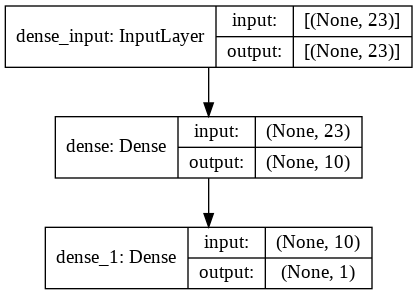

In [40]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, 
                    y_train,
                    epochs = 100,
                    batch_size = 64,
                    verbose=2, validation_split=0.1)

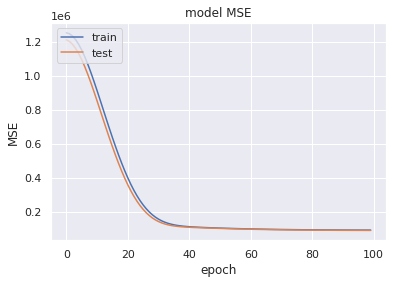

In [42]:
# summarize history for accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
eval = model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step - loss: 96295.7266 - mean_squared_error: 96295.7266


In [44]:
np.sqrt(eval[0])

310.3155274273268

In [51]:
model = Sequential()
model.add(Dense(256,activation='relu',input_shape = (23,)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(optimizer = 'adam', loss='mean_squared_error',
             metrics=mean_squared_error)


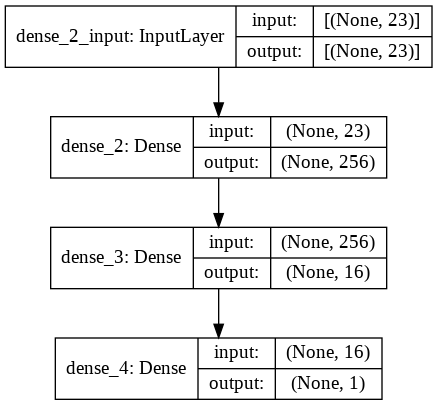

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               6144      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                4112      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 10,273
Trainable params: 10,273
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit(X_train, 
                    y_train,
                    epochs = 20,
                    batch_size = 32,
                    verbose=0, validation_split=0.1)

In [48]:
eval = model.evaluate(X_test, y_test)
np.sqrt(eval[0])

63/63 [==============================] - 0s 3ms/step - loss: 96367.0000 - mean_squared_error: 96367.0000


310.43034645472403

In [52]:
model = Sequential()
model.add(Dense(256,activation='relu',input_shape = (23,)))
model.add(Dropout(0.3)) # <<-- Added dropout
model.add(Dense(16,activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(optimizer = 'adam', loss='mean_squared_error',
             metrics=mean_squared_error)


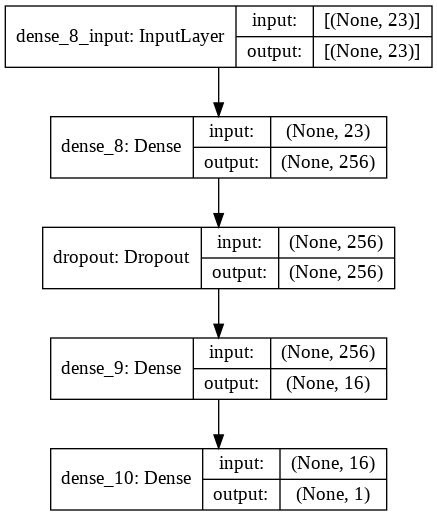

In [53]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [54]:
history = model.fit(X_train, 
                    y_train,
                    epochs = 20,
                    batch_size = 32,
                    verbose=0, validation_split=0.1)

In [55]:
eval = model.evaluate(X_test, y_test)
np.sqrt(eval[0])

63/63 [==============================] - 0s 2ms/step - loss: 95906.7969 - mean_squared_error: 95906.7969


309.6882252766482

In [56]:
from keras.regularizers import l1

In [57]:
model = Sequential()
model.add(Dense(256,activation='relu',input_shape = (23,)))
model.add(Dense(16,activation='relu',  activity_regularizer=l1(0.001))) # <-- add activity regularizer
model.add(Dense(1, kernel_initializer='normal'))
model.compile(optimizer = 'adam', loss='mean_squared_error',
             metrics=mean_squared_error)

history = model.fit(X_train, 
                    y_train,
                    epochs = 20,
                    batch_size = 32,
                    verbose=0, validation_split=0.1)

In [58]:
eval = model.evaluate(X_test, y_test)
np.sqrt(eval[0])

63/63 [==============================] - 0s 2ms/step - loss: 95281.7031 - mean_squared_error: 95279.7344


308.67734469021207

In [62]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

In [64]:
# define two sets of inputs
inputA = Input(shape=(4,))
inputB = Input(shape=(19,))

# the first branch operates on the first input
x1 = Dense(4, activation="relu")(inputA)
x1 = Dense(4, activation="relu")(x1)
x1 = Model(inputs=inputA, outputs=x1)

# the second branch opreates on the second input
x2 = Dense(8, activation="relu")(inputB)
x2 = Dense(4, activation="relu")(x2)
x2 = Model(inputs=inputB, outputs=x2)

# combine the output of the two branches
combined = concatenate([x1.output, x2.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
y = Dense(2, activation="relu")(combined)
y = Dense(1, activation="relu")(y)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x1.input, x2.input], outputs=y)

In [65]:
model.compile(optimizer = 'adam', loss='mean_squared_error',
             metrics=mean_squared_error)

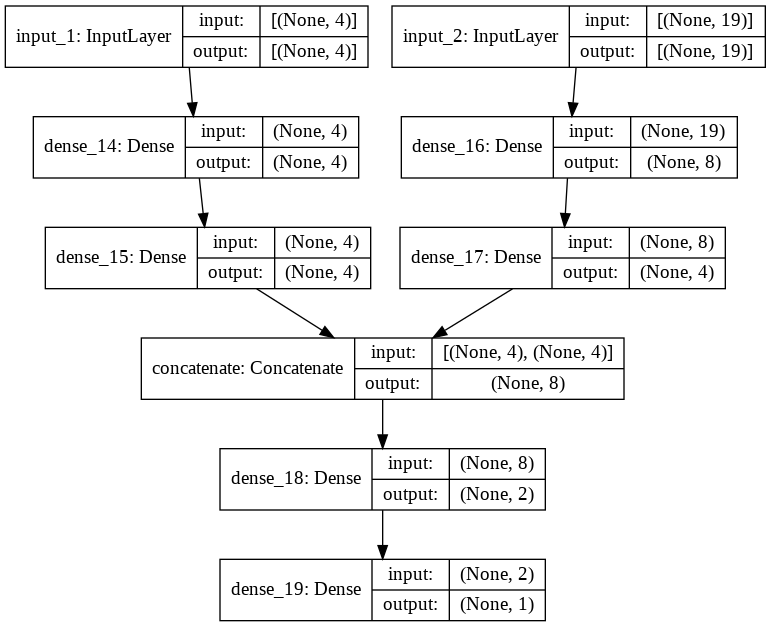

In [66]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit([X_train.iloc[:,:4],X_train.iloc[:,4:]], 
                    y_train,
                    epochs = 100,
                    batch_size = 64,
                    verbose=1, validation_split=0.1)

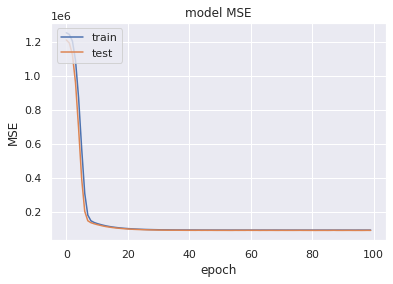

In [68]:
# summarize history for accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [69]:
eval = model.evaluate([X_test.iloc[:,:4],X_test.iloc[:,4:]], y_test)
np.sqrt(eval[0])

63/63 [==============================] - 0s 3ms/step - loss: 95844.5312 - mean_squared_error: 95844.5312


309.58767942216303